In [1]:
from IPython.display import display,HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<font color=#0099ff size=4 face="黑体">
Linear Regression implenmentation<br>
@Author: Ge Chen<br>
@Time: 2019-8-23<br>
</font>

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [92]:
class LinearRegression():
    def loadDataSet(self, filename):
        """
        Desc:
            load data from .txt file
        Args:
            filename -- .txt file path
        Returns:
            dataMat -- feature matrix, list type
            labelMat -- sample labels, list type
        """
        dataMat, labelMat = [], []
        with open(filename) as fr:
            for line in fr.readlines():
                lineArr = []
                curLine = line.strip().split('\t')
                for i in range(len(curLine) - 1):
                    lineArr.append(float(curLine[i]))
                dataMat.append(lineArr)
                labelMat.append(float(curLine[-1]))
        return dataMat, labelMat
    
    def standRegres(self, xArr, yArr):
        """
        Desc:
            standard linear regression.
            Cost function is Σ(yi - h(xi))^2, in vector version is (y-Xw)T * (y-Xw)
        Args:
            xArr -- feature matrix
            yArr -- labels
        Returns:
            ws -- weight coeffient
        """
        xMat = np.mat(xArr)
        yMat = np.mat(yArr).T
        xTx = xMat.T * xMat
        if np.linalg.det(xTx) == 0.0:
            print ("This matrix is singular, connot do inverse")
            return
        ws = xTx.I * (xMat.T * yMat)
        return ws
    
    def lwlr(self, testpoint, xArr, yArr, k = 1.0):
        """
        Desc:
            local weighted linear regression.
            It is a non-parameter algorithm, and it has no training process, like KNN.
            The main idea is giving a weight coeffient to every existing sample.
            在做预测时，更多地参考距离预测样本近的已知样本，而更少地参考距离预测样本远的已知样本。
            本function一次只预测一个点.
            The cose function: Σw(yi - h(xi))^2, w is matrix (m, m), diagonal matrix
                                w(i) = exp(x(i) - x)^2 / -2k^2
            Advantages: 1. 可以拟合非线性回归
                        2. 不容易欠拟合
            Disadvantages: 1. 需要永远保留所有样本
                           2. 计算量大
                    
            More reference:
                http://cynhard.com/2018/07/13/ML-Locally-Weighted-Linear-Regression/
                https://zhuanlan.zhihu.com/p/22064801
            
        Args:
            testpoint -- sample point
            xArr -- feature matrix
            yArr -- labels
            k -- a parameter of kernel function, which is related with decay rate
        Returns:
            testPoint * ws -- the predictions
        """
        xMat = np.mat(xArr)
        yMat = np.mat(yArr).T
        m = np.shape(xMat)[0]
        # np.array: Return a 2-D array with ones on the diagonal and zeros elsewhere.
        weights = np.mat(np.eye(m))
        for j in range(m):
            diffMat = testpoint - xMat[j, :]
            weights[j, j] = np.exp((diffMat * diffMat.T) / (-2.0 * k**2))
        xTx = xMat.T * (weights * xMat)
        if np.linalg.det(xTx) == 0:
            print ("This matrix is singular, connot do inverse")
            return
        ws = xTx.I * (xMat.T * (weights * yMat))
        return testpoint * ws
    
    def lwlrTest(self, testArr, xArr, yArr, k = 1.0):
        """
        Desc:
            call lwlr() for every test sample
        Args:
            testArr -- test sample set
            xArr -- feature matrix
            yArr -- labels
            k -- a parameter of kernel function, which is related with decay rate
        Returns:
            yHat -- the predicted results for every sample point
        """
        m = np.shape(testArr)[0]
        yHat = np.zeros(m)
        for i in range(m):
            yHat[i] = self.lwlr(testArr[i], xArr, yArr, k)
        return yHat
    
    def ridgeRegres(self, xMat, yMat, lam=0.2):
        """
        Desc:
            ridge regression
            When the feature number is greater than the sample number, or 
            several columns are colinear (或者线性相关性比较大),
            the determinant of xTx may be close to 0. The error will be significant is this case.
            so we added a term αI to convert the ill-posed problem into well-posed problem.
            The cost function is ||y - Xw||^2 + ||λw||^2
        Args:
            xMat -- feature matrix
            yMat -- labels
            lam -- lambda
        """
        xTx = xMat.T * xMat
        denom = xTx + np.eye(np.shape(xMat)[1]) * lam
        if np.linalg.det(denom) == 0:
            print ("This matrix is singular, connot do inverse")
            return
        ws = denom.I * (xMat.T * yMat)
        return ws
    
    def ridgeTest(self, xArr, yArr):
        """
        Desc:
            standardize the training set and adjust lambda to get several ws
        Args:
            xArr -- feature matrix
            yArr -- labels
        Returns:
            wMat -- a matrix storing ws in different lambda. Each row is a ws vector.
        """
        xMat = np.mat(xArr)
        yMat = np.mat(yArr).T
        yMean = np.mean(yMat, 0) # average y
        xMeans = np.mean(xMat, 0) # average x (vector)
        xVar = np.var(xMat, 0) # variance of x
        xMat = (xMat - xMeans) / xVar # standardization
        
        # adjust lambda 
        numTestPts = 30
        # store ws in different lambdas, (numTestPts, n)
        wMat = np.zeros((numTestPts, np.shape(xMat)[1]))
        for i in range(numTestPts):
            ws = self.ridgeRegres(xMat, yMat, np.exp(i - 10))
            wMat[i, :] = ws.T
        return wMat
    
    def rssError(self, yArr, yHatArr):
        """
        Desc:
            calcuate the RSS
        Args:
            yArr -- actual y
            yHatArr -- predicted y
        Returns:
            RSS
        """
        return (((yArr - yHatArr)) ** 2).sum()
    
    def stageWise(self, xArr, yArr, eps=0.01, numIt=100):
        """
        Desc:
            stageWise linear regression. Greedy Algorithm.
            不断增加或减小某个权重值，计算RSS，直到找到最小的RSS或完成给定的迭代次数
        Args:
            xArr -- feature matrix
            yArr -- labels
            eps -- step size
            numIt -- iteration time
        Returns:
            returnMat -- a matrix stored ws in each iteration step
        """
        xMat = np.mat(xArr)
        xMeans = np.mean(xMat, 0) # average x (vector)
        xVar = np.var(xMat, 0) # variance of x
        xMat = (xMat - xMeans) / xVar # standardization
        
        yMat = np.mat(yArr).T
        yMean = np.mean(yMat, 0) # average y
        yMat = yMat - yMeans # why we changed y?
        
        m, n = np.shape(xMat)
        returnMat = np.zeros((numIt, n))
        ws = np.zeros((n, 1))
        wsTest = ws.copy()
        wsMax = ws.copy()
        
        # start iteration
        for i in range (numIt):
            print (ws.T)
            lowestError = inf
            # in each iteration step, change a weight coeffient.
            # find the lowest RSS
            for j in range(n):
                for sign in [-1, 1]:
                    wsTest = ws.copy()
                    wsTest[j] += eps * sign
                    yTest = xMat * wsTest
                    rssE = self.rssError(yMat.A, yTest.A)
                    if rssE < lowestError:
                        lowestError = rssE
                        wsMax = wsTest
            ws = wsMax.copy()
            returnMat[i, :] = ws.T
        return returnMat
        
        
    
    
    def regression1(self):
        xArr, yArr = self.loadDataSet(r'..\data\Ch08\ex0.txt')
        xMat = np.mat(xArr)
        yMat = np.mat(yArr)
        ws = self.standRegres(xArr, yArr)
        fig = plt.figure()
        ax = fig.add_subplot(111)               #add_subplot(349)函数的参数的意思是，将画布分成3行4列图像画在从左到右从上到下第9块
        
        ax.scatter([xMat[:, 1].flatten()], [yMat.T[:, 0].flatten().A[0]]) #scatter 的x是xMat中的第二列，y是yMat的第一列
        xCopy = xMat.copy() 
        xCopy.sort(0)
        yHat = xCopy * ws
        ax.plot(xCopy[:, 1], yHat)
        plt.show()

    def regression2(self):
        xArr, yArr = self.loadDataSet(r'..\data\Ch08\ex0.txt')
        yHat = self.lwlrTest(xArr, xArr, yArr, 0.01)
        xMat = np.mat(xArr)
        srtInd = xMat[:, 1].argsort(0)  # argsort()函数是将x中的元素从小到大排列，提取其对应的index(索引)，然后输出
        xSort = xMat[srtInd][:, 0, :]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(xSort[:, 1], yHat[srtInd])
        ax.scatter([xMat[:, 1].flatten().A[0]], [np.mat(yArr).T.flatten().A[0]], s=2, c='red')
        plt.show()
        
    def regression3(self):
        abX, abY = self.loadDataSet(r'..\data\Ch08\abalone.txt')
        ridgeWeights = self.ridgeTest(abX, abY)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(ridgeWeights)
        plt.show()

    def regression4(self):
        xArr, yArr = self,loadDataSet(r'..\data\Ch08\abalone.txt')
        self.stageWise(xArr, yArr, 0.01, 200)
        xMat = np.mat(xArr)
        yMat = np.mat(yArr).T
        xMat = self.regularize(xMat)
        yM = mean(yMat, 0)
        yMat = yMat - yM
        weights = self.standRegres(xMat, yMat.T)
        print(weights.T)
    
            

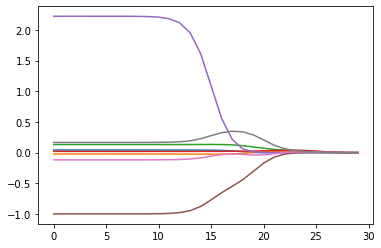

In [93]:
LR = LinearRegression()
LR.regression1()
LR.regression2()
LR.regression3()